<a href="https://colab.research.google.com/github/Sebanthalas/fem-dnn/blob/main/Test_FEM_NSE_UQvisco_PURE_DIRICHLET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
%cd drive/MyDrive/project_dnn
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time
import os, sys, shutil
from google.colab import files
#!python -m pip install Tasmanian --user
!pip install hdf5storage


[Errno 2] No such file or directory: 'drive/MyDrive/project_dnn'
/content/drive/MyDrive/project_dnn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:


'''
Mixed scheme of the Navier--Stokes-- equations
The domain is unit square with  Diirichlet BC

 
#######################################
strong primal form: 

  *div(mu*eps(u)) + grad(u)*u + grad(p) = f  in Omega
                                           div(u) = 0  in Omega 

Pure Dirichlet conditions for u 
                                                u = u_D on Gamma

Lagrange multiplier to fix the average of p
                                           int(p) = 0

######################################


######################################

parametric  viscoscity: mu(x,y)
'''
%cd drive/MyDrive/project_dnn
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers, regularizers
# Other libraries
import scipy.io as sio
from fenics import *
#import Tasmanian
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import linalg as la
import time, os, argparse, io, shutil, sys, math, socket
import scipy.io as sio
from dolfin import *
import sympy2fenics as sf
import random
import os
!pwd

[Errno 2] No such file or directory: 'drive/MyDrive/project_dnn'
/content/drive/MyDrive/project_dnn
/content/drive/MyDrive/project_dnn


In [108]:

# ==============================================================
# The sympy2fenics.py file is needed to compute in a simple way:
# - derivatives
# - tensor products
# ==============================================================
# Define essential boundary
def boundary(x):
    return   x[0] > 1.0 - DOLFIN_EPS
def my_LK_fun(x,z,d):
  pi = 3.14159265359
  pi_s = pi
  L_c = 1.0/8.0
  L_p = np.max([1.0, 2.0*L_c])
  L_c_s = L_c
  L_p_s = L_p
  L = L_c/L_p
  L_s = L
  string = -1.2+sqrt(sqrt( pi_s )*  L_s /2.0)* z[0]
  for j in range(2, input_dim):
    term = z[j-1]*sqrt(sqrt(pi_s)*L_s )*exp(-pow(np.floor(j/2.0)* pi*L_s,2.0)/8.0)
    if j % 2 == 0:
      term = term*sin(np.floor(j/2.0)* pi_s*x/L_p_s)
    else:
      term = term*cos(np.floor(j/2.0)* pi_s*x/L_p_s)
    string = string + term
  string = np.exp(  string )
  return(string) 
def str2exp(s):
    return sf.sympy2exp(sf.str2sympy(s))
def coeff_extr(j):
    #This exctracts the coefficient of the different spaces
    # j is the index of the space:
    # j=o the vector space for uh
    # j=1 the space for  component of te11
    # j=2 the space for  component of te12
    # j=3 the space for  component of te21
    # j=4 the first  row of sigma
    # j=5 the second row of sigma
    # j=6 the lagrange multiplier (not uch important)
    # For this to work the nature of the space has to be the same
    W  = Function(Hh)
    #Getting the exact DOF location
    DoF_map   = Hh.sub(j).dofmap()
    DoF_index = DoF_map.dofs()
    AUX1 = W.vector().get_local()    # empty DoF vector 
    AUX2 = Usol.vector().get_local() # All DoF
    AUX1[DoF_index] = AUX2[DoF_index]                # corresponding assignation
    W.vector().set_local(AUX1)       # corresponding assignation to empy vector
    coeff_vector = np.array(W.vector().get_local()) 
    return coeff_vector
# ==============================================================
# Boundary conditions
# ============================================================== MyExpressionoutlet
#class MyExpression(UserExpression):
#  def eval(self, value, x):
#    if x[1] >= 1- DOLFIN_EPS:#-my_LK_fun(x[0],z,d):
#      value[0] = 0.0
#    elif x[1] <= 0.0+ DOLFIN_EPS:#+my_LK_fun(x[0],z,d):
#      value[0] = 0.0
#    elif x[0] > 1- DOLFIN_EPS:
#      value[0] = ( 1.0 - ( abs(abs(x[1]) - 0.5 ))/(0.5)  ) 
#    elif x[0] < 0.0+ DOLFIN_EPS:
#      value[0] = ( 1.0 - ( abs(abs(x[1]) - 0.5 ))/(0.5)  ) 
#    elif ( (x[0] > 0.0625 - DOLFIN_EPS) and (x[0] < 0.1875 +DOLFIN_EPS) and (x[1] > 0.4375 - DOLFIN_EPS) and (x[1] < 0.5625 + DOLFIN_EPS) ):
#      value[0] = 0.0   
#    else:
#      value[0] = 0.0
#  def value_shape(self):
#    return (1,)

# ==============================================================
# The following gives the informations about the solver. 
# ==============================================================
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = 4
list_linear_solver_methods()
# ==============================================================
# Define the parameters for the PDE and SG points
# ==============================================================
# All parameters
default_parameters = {
  'trial_': 1,
	'num_train_samples':1, #20
	'num_test_samples': 0, #50
  'mesh_op': 3, # choose mesh refiniment, 1,2,3,4. Default=2
	'FE_degree': 1, # Use P1 for 2D or above
  'example' : 'other',
  'input_dim': 4
}
params = default_parameters
exact_FE_soln = 0
using_SG_points =0
#random samples
_trial = params['trial_']
np_seed = _trial
np.random.seed(np_seed)
 
#================================================================
# Choose the mesh: there is 4  barycentric refininements. 
#                  - use plot(mesh) to see them.
#================================================================
nk = params['mesh_op']
example = params['example']
input_dim = params['input_dim']
meshname="meshes/unit_square/obstac%03g.xml"%nk
mesh = Mesh(meshname)
bdry = MeshFunction("size_t", mesh, "meshes/unit_square/subdomains.xml")
wall = 0; inlet=1; outlet=2;
nn   = FacetNormal(mesh)
tan  = as_vector((-nn[1],nn[0])) # DIMMMMMM
    
ds = Measure("ds", subdomain_data = bdry)
dx = Measure("dx", domain=mesh)

uinlet = Expression(('( 1.0 - ( abs(abs(x[1]) - 0.5 ))/(0.5)  ) ','0'), degree = 2)
#================================================================
# only for errors
#================================================================
hvec = mesh.hmax(); # pick the h_max from the mesh
nvec = 0;           # Same number as K
#================================================================
# The following for is not necessary. I use it when I want to obtain results
# for different values of m
#================================================================
for m in [1]:
    All_Train_coeff   = []
    All_Train_coeff_p = []
    All_Test_coeff    = []
    All_Test_coeff_p  = []
    _L4unorm= []
    _L2tnorm= []
    _L2pnorm= []
    _L2snorm= []
    input_dim = params['input_dim']
    Nu = m
    d = input_dim       # parametric dimension
    y_in_train = 2.0*np.random.rand(d,m) - 1.0  # training points    
    Re = Constant(150)
    g     = Constant((0.,0.))
    f     = Constant((0.0,0.))
    cero  = Constant((0.,0.))
    upper = Constant((10.,0.))
    Id    = Constant(((1.,0.),(0.,1.)))
    #y_in_train = (2.0*np.random.rand(d,m) - 1.0)
    # Generate the training data
    for i in range(m):
      coeff_each_m = []
      coeff_each_m_p = []
      # time
      t_start = time.time()
      # Paramters
      z = y_in_train[:,i]
      # ******* Exact solutions for error analysis ****** 
      #================================================================
      # The viscosity of the fluid depends on the parameters
      #================================================================
      
      if example == 'logKL_expansion':
         pi = 3.14159265359
         pi_s = str(pi)
         L_c = 1.0/8.0
         L_p = np.max([1.0, 2.0*L_c])
         L_c_s = str(L_c)
         L_p_s = str(L_p)
         L = L_c/L_p
         L_s = str(L)      
         string = '-4.5+sqrt(sqrt(' + pi_s + ')*' + L_s + '/2.0)*' + str(z[0])
         for j in range(2, input_dim):
           term = str(z[j-1]) + '*sqrt(sqrt(' + pi_s + ')*' + L_s + ')*exp(-pow(floor('
           term = term + str(j) + '/2.0)*' + pi_s + '*' + L_s + ',2.0)/8.0)' 
           if j % 2 == 0:
             term = term + '*sin(floor(' + str(j) + '/2.0)*' + pi_s + '*x/' + L_p_s + ')'
           else:
             term = term + '*cos(floor(' + str(j) + '/2.0)*' + pi_s + '*x/' + L_p_s + ')'
           string = string + '+' + term
         string = 'exp(' + string + ')'
      else:# use a simple example where only the first two dimensions have x dependence
        string = 1/150
        #string = '5.0+exp(' + str(z[0]) + '+' + str(z[1]) + '+' + str(z[2]) + '+'+ str(z[3]) +' )' 
        
      #mu = Expression(str2exp(string), degree=2, domain=mesh)
      #mu = Constant(string)
      mu = Constant(1/0.1)
      #================================================================
      # Boundary condition
      #================================================================ 
 
    #================================================================
    #  *********** Finite Element spaces ************* #
    #================================================================
      deg= params['FE_degree']
      Pkv = VectorElement('DG', mesh.ufl_cell(), deg)
      Pk  = FiniteElement('DG', mesh.ufl_cell(), deg+1)
      RTv = FiniteElement('BDM', mesh.ufl_cell(), deg+1)
      R0  = FiniteElement('R', mesh.ufl_cell(), 0)
      Hh  = FunctionSpace(mesh, MixedElement([Pkv,Pk,Pk,Pk,RTv,RTv,R0]))
      Ph  = FunctionSpace(mesh,'CG',1)
      nvec = Hh.dim()
     #================================================================
     # *********** Trial and test functions ********** #
     #================================================================
      Utrial = TrialFunction(Hh)
      Usol   = Function(Hh)
      W_trainsol   = Function(Hh)
      u, t11, t12, t21, Rsig1, Rsig2, xi= split(Usol)
      v, s11, s12, s21, Rtau1, Rtau2, ze= TestFunctions(Hh)
      t = as_tensor(((t11,t12),(t21,-t11)))
      s = as_tensor(((s11,s12),(s21,-s11))) 
      sigma = as_tensor((Rsig1,Rsig2))
      tau   = as_tensor((Rtau1,Rtau2))
      # ********** Boundary conditions ******** #
      # All Dirichlet BCs become natural in this mixed form 
      # *************** Variational forms ***************** #
      #================================================================
      # flow equations
      #================================================================   
      # Weak formulation  
      BigA = - dot(div(sigma),v)*dx + 0.5*dot(t*u,v)*dx
      BigB = 2.*mu*inner(sym(t),s)*dx - 0.5*inner(dev(outer(u,u)),s)*dx - inner(dev(sigma),s)*dx 
      BigC = inner(tau,t)*dx  + dot(u,div(tau))*dx
      # right part and boundary equation
      F  = dot(g+f,v)*dx
      G  = dot(tau*nn,uinlet)*ds(inlet) +dot(tau*nn,uinlet)*ds(outlet)
      # zero average of trace
      Z  = (tr(2*sigma+outer(u,u))) * ze * dx + tr(tau) * xi * dx
      #Stiffness matrix
      FF = BigA + BigB + BigC  - F - G  + Z   
    	# solver						  
      Tang = derivative(FF, Usol, Utrial)
      solve(FF == 0, Usol, J=Tang)
      #Solutions
      uh, t11h, t12h, t21h, Rsigh1, Rsigh2, xih = Usol.split()
      th=as_tensor(((t11h,t12h),(t21h,-t11h)))					    
      sigmah = as_tensor((Rsigh1,Rsigh2))        
      # dimension-dependent (not separating H_0(div) with c*I)
      #getting coeffiecients of p
      ph = project(-0.25*tr(2*sigmah+outer(uh,uh)),Ph)
      coeff_each_m_p = ph.vector().get_local()
      All_Train_coeff_p.append(coeff_each_m_p)
      #
      num_subspaces = W_trainsol.num_sub_spaces()-1
      for j in range(num_subspaces):
        coef_one_trial = coeff_extr(j)
        coeff_each_m.append(coef_one_trial)
      All_Train_coeff.append(coeff_each_m)
      print('====================================================================')
      print('i = ', i, ' ', y_in_train[:,i])
      print('====================================================================')
      L4unorm  = sqrt(sqrt(assemble( ((uh)**2)**2*dx)))
      L2tnorm  = sqrt(assemble( (th)**2*dx ))
      L2pnorm  = sqrt(assemble((ph)**2*dx) ) 
      L2snorm  = sqrt(assemble((sigmah)**2*dx) ) 
      print(L4unorm,L2tnorm,L2pnorm)
      _L4unorm.append(L4unorm)
      _L2tnorm.append(L2tnorm)
      _L2pnorm.append(L2pnorm)
      _L2snorm.append(L2snorm)

     
      if i == 0:
        K = len(All_Train_coeff[0][0])
        print('FE degrees of freedom K = ',K)
      if exact_FE_soln:
        # Compute error in L4 and L2 norms
        erroru_L4 = sqrt(sqrt(assemble( ((u_ex-uh)**2)**2*dx)))
        errort_L2 = sqrt(assemble((th-t_ex)**2*dx))
        errorp_L2 = sqrt(assemble((ph-p_ex)**2*dx)) 
        errorp_Hdiv4_3 = sqrt(assemble((sigma_ex-sigmah)**2*dx) ) +  pow(  assemble(  ( pow(  ( div(sigma_ex)-div(sigmah)  )**2,2.0/3.0 )**1*dx)  )  , 3.0/4.0 )   
        # Compute maximum error at vertices
        vertex_values_u_ex= u_ex.compute_vertex_values(mesh)
        vertex_values_uh   = uh.compute_vertex_values(mesh)
        error_max         = np.max(np.abs(vertex_values_u_ex - vertex_values_uh))
        timer =time.time() - t_start
        # Print errors
        print('i = ', i, ' ', y_in_train[:,i])
        print('====================================================================')
        print(' h    &   e(u)     &  e(t)   &    e(p)   &    e(si)   &   e_m(u) &   time ')
        print('====================================================================')
        print('%5.5g     %4.4g    %4.4g    %4.4g      %4.4g       %4.4g     %4.4g  ' % (hvec, erroru_L4, errort_L2, errorp_L2, errorp_Hdiv4_3, error_max,timer ))
        print('======================================================================')
    print('Generated inputs of size: ', y_in_train.shape)
    print('Generated outputs of size: ', coef_one_trial.shape[0])
 

i =  0   [-0.16595599  0.44064899 -0.99977125 -0.39533485]
0.6773849319050294 6.529159442523303 222.02818540287615
FE degrees of freedom K =  46735
Generated inputs of size:  (4, 1)
Generated outputs of size:  46735


In [ ]:
====================================================================
i =  0   [-0.16595599  0.44064899 -0.99977125 -0.39533485]
====================================================================
0.6773849319050287 6.529159442523299 222.028185402876
FE degrees of freedom K =  46735
Generated inputs of size:  (4, 1)
Generated outputs of size:  46735
Generating the testing data
Generated inputs of size:  (4, 0)
Generated outputs of size:  (46735,)

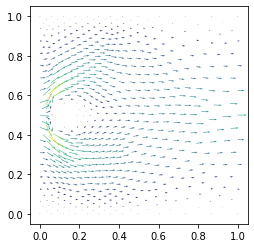

In [109]:
plot(uh)

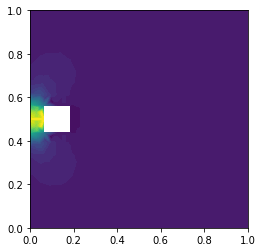

In [76]:
plot(ph)

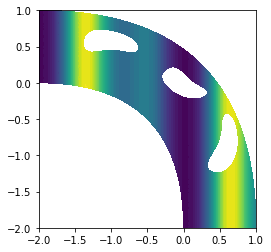

In [ ]:
muh =project(mu,Ph) 
plot(muh)

9.921567416492216

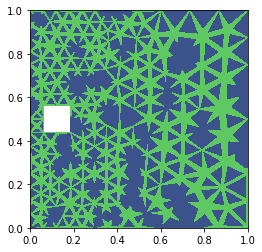

In [78]:
muh =project(mu,Ph) 
plot(muh)
norm(muh)

In [19]:
D = mesh.topology().dim()
mf = MeshFunction("size_t", mesh, D - 1, mesh.domains())
 

In [67]:
# Sub domain for no-slip (mark whole boundary, inflow and outflow will overwrite)
class Noslip(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary

# Sub domain for inflow (right)
class Inflow(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] <  DOLFIN_EPS and on_boundary

# Sub domain for outflow (left)
class Outflow(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] > 1- DOLFIN_EPS and on_boundary
# Create mesh functions over the cell facets
sub_domains = MeshFunction("size_t", mesh, D- 1)
sub_domains_bool = MeshFunction("bool", mesh, D - 1)
sub_domains_double = MeshFunction("double", mesh, D- 1)
# Mark all facets as sub domain 3
sub_domains.set_all(3)
sub_domains_bool.set_all(False)
sub_domains_double.set_all(0.3)
# Mark no-slip facets as sub domain 0, 0.0
noslip = Noslip()
noslip.mark(sub_domains, 0)
noslip.mark(sub_domains_double, 0.0)
# Mark inflow as sub domain 1, 01
inflow = Inflow()
inflow.mark(sub_domains, 1)
inflow.mark(sub_domains_double, 0.1)
# Mark outflow as sub domain 2, 0.2, True
outflow = Outflow()
outflow.mark(sub_domains, 2)
outflow.mark(sub_domains_double, 0.2)
outflow.mark(sub_domains_bool, True)
# Save sub domains to file
file = File("meshes/unit_square/subdomains.xml")
file << sub_domains

In [56]:
ds(100)

Measure('exterior_facet', subdomain_id=100)

In [64]:
sub_domains.label()

'unnamed MeshFunction'